## Retrieval-Augmented Generation (RAG) from PDFs with Local Vector Storage (ChromaDB), Enhanced Reflection, and Iterative Self-Correction


### Mermaid Flowchart (optional)

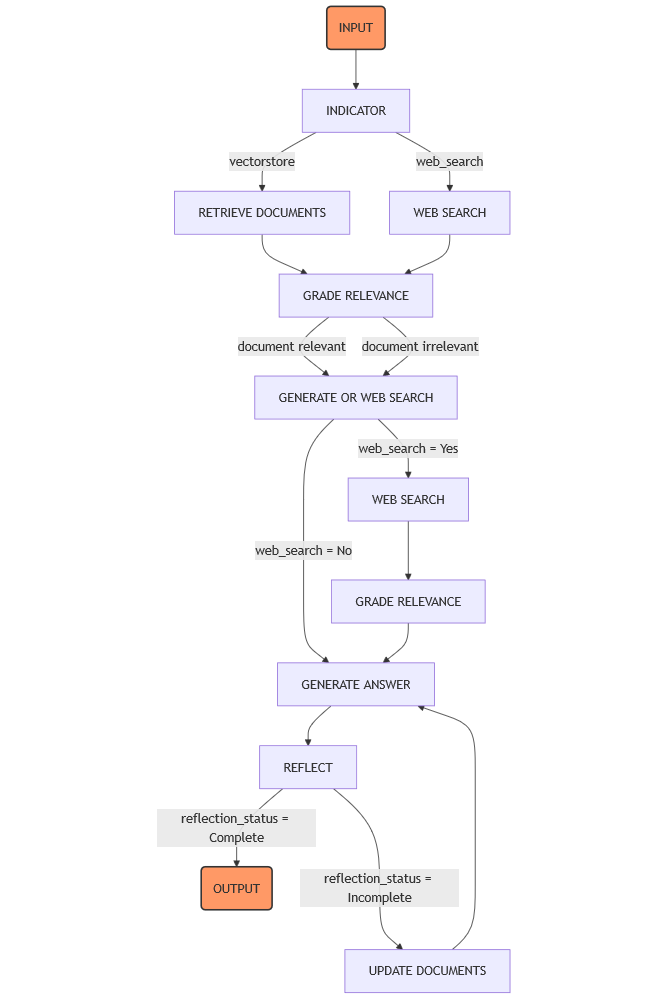

In [127]:
# from IPython.display import Image
# Image(filename='C:\\Users\\GGPC\\Desktop\\Work\\RAG_Local_LLM\\mermaid-diagram-2024-09-11-172236.png', width=500)

In [ ]:
# graph TD
#     START(INPUT) --> IndicationQuestion[INDICATOR]
    
#     IndicationQuestion -->|web_search| Websearch[WEB SEARCH]
#     IndicationQuestion -->|vectorstore| Retrieve[RETRIEVE DOCUMENTS]
    
#     Retrieve --> GradeRelevance[GRADE RELEVANCE]
#     Websearch --> GradeRelevance
    
#     GradeRelevance -->|document relevant| GenerateOrWebSearch[GENERATE OR WEB SEARCH]
#     GradeRelevance -->|document irrelevant| GenerateOrWebSearch[GENERATE OR WEB SEARCH]
    
#     GenerateOrWebSearch -->|web_search = Yes| WebsearchAgain[WEB SEARCH]
#     GenerateOrWebSearch -->|web_search = No| Generate[GENERATE ANSWER]
    
#     WebsearchAgain --> GradeRelevanceAgain[GRADE RELEVANCE]
#     GradeRelevanceAgain --> Generate[GENERATE ANSWER]
    
#     Generate --> Reflect[REFLECT]
    
#     Reflect -->|reflection_status = Complete| END(OUTPUT)
#     Reflect --->|reflection_status = Incomplete| UpdateDocuments[UPDATE DOCUMENTS]

#     UpdateDocuments --> Generate
    
#     classDef startEnd fill:#f96,stroke:#333,stroke-width:2px;
#     class START,END startEnd;


### Imports

In [85]:
import os
from dotenv import load_dotenv

from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from typing import List
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_community.vectorstores import Chroma
import ollama
import chromadb

In [86]:
load_dotenv()

tavily_api_key = os.getenv("TAVILY_API_KEY")

### Model

In [87]:
# Embedding models
JSONparser = JsonOutputParser()
STRparser = StrOutputParser()


### Embedding function

In [88]:
# Define embedding function
def get_embedding(text):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=text)
    return response["embedding"]

### Accessing PDF files

In [89]:
# Process PDF files
def op2_process_pdf_files(folder_path, prefix, suffix):
    chunks = []
    pdf_files = [file for file in os.listdir(folder_path) if file.startswith(prefix) and file.endswith(suffix)]
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)
        loader = PyPDFLoader(pdf_path)
        document = loader.load()
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=800,
            chunk_overlap=80,
            length_function=len
        )
        document = text_splitter.split_documents(document)
        
        chunks.extend(document)
        print(f"Processed: {pdf_file}")
        
    print(f"All {len(pdf_files)} files processed successfully.")
    print(f"Total number of chunks loaded: {len(chunks)}")
    
    return chunks

folder_path = r"C:\Users\GGPC\Desktop\Work\RAG_Local_LLM\data"
prefix = "H1 Residential"
suffix = ".pdf"

chunks = op2_process_pdf_files(folder_path, prefix, suffix)

Processed: H1 Residential - Large Lot Zone.pdf
All 1 files processed successfully.
Total number of chunks loaded: 31


In [90]:
def get_chunk_ids(chunks):
    # Id format: Page Source : Page Number : Chunk Index
    
    chunk_counter = {}
    
    for chunk in chunks:
        page = chunk.metadata.get("page")
        source = chunk.metadata.get("source")
        current_page_id = f"{source}:{page}"
        
        # chunk index counter
        if current_page_id not in chunk_counter:
            chunk_counter[current_page_id] = 0
        else:
            chunk_counter[current_page_id] += 1

        # calculate chunk id
        chunk_id = f"{current_page_id}:{chunk_counter[current_page_id]}"
        
        # update chunk metadata
        chunk.metadata["id"] = chunk_id
    
    return chunks

# Get chunk ids
chunks = get_chunk_ids(chunks)

In [91]:
# Initialize the Chroma client
CHROMA_PATH = "chroma_db2"
client = chromadb.PersistentClient(path=CHROMA_PATH)

In [92]:
# Get or create a collection
collection_name = "docs"
collection = client.get_or_create_collection(name=collection_name)

In [93]:
# Add documents to the collection
existing_ids = set(collection.get()["ids"])
new_chunks = [chunk for chunk in chunks if chunk.metadata.get("id") not in existing_ids]

if new_chunks:
    print(f"👉 Adding new documents: {len(new_chunks)}")
    for chunk in new_chunks:
        embedding = get_embedding(chunk.page_content)
        collection.add(
            ids=[chunk.metadata["id"]],
            embeddings=[embedding],
            documents=[chunk.page_content],
            metadatas=[chunk.metadata]
        )
else:
    print("✅ No new documents to add")

print(f"Total documents in DB: {len(collection.get()['ids'])}")

✅ No new documents to add
Total documents in DB: 31


### Embedding and Retrieval

In [94]:
class ChromaEmbeddingFunction:
    def __init__(self, model_name: str):
        self.model_name = model_name

    def __call__(self, texts: List[str]) -> List[List[float]]:
        return [self.embed_query(text) for text in texts]

    def embed_query(self, text: str) -> List[float]:
        response = ollama.embeddings(model=self.model_name, prompt=text)
        return response["embedding"]

# Use this wrapper class when creating the vectorstore
embedding_function = ChromaEmbeddingFunction("mxbai-embed-large")

In [95]:
# Create the vectorstore and retriever
vectorstore = Chroma(
    client=client,
    collection_name=collection_name,
    embedding_function=embedding_function
)
retriever = vectorstore.as_retriever()

In [96]:
retriever = vectorstore.as_retriever()

retriever.invoke("what are the permitted activities?")

[Document(metadata={'id': 'C:\\Users\\GGPC\\Desktop\\Work\\RAG_Local_LLM\\data\\H1 Residential - Large Lot Zone.pdf:1:1', 'page': 1, 'source': 'C:\\Users\\GGPC\\Desktop\\Work\\RAG_Local_LLM\\data\\H1 Residential - Large Lot Zone.pdf'}, page_content='(b) are compatible with the scale and intensity of development anticipated \nwithin the zone; and  \n(c) avoid, remedy or mitigate adverse effects on residential amenity; and  \n(d) will not detract from the vitality of the Business – City Centre  Zone , \nBusiness – Metro politan  Centre Zone and the Business – Town \nCentre Zone.  \nH1.4.  Activity table  \nTable H1.4.1 Activity t able specifies the activity status of land use and development  \nactivities in the Residential – Large Lot Zone pursuant to section 9(3) of the Resource \nManagement Act 1991.    \nTable  H1.4.1 Activity table \nActivity  Activity \nstatus  Standards to be complied with  \nUse \n(A1) Activities not provided for  NC  \nResidential  \n(A2) Camping grounds  D  \n(

### Setting up the models and Testing

In [97]:
# Setting up the 'setup' part of chain
setup = RunnableParallel(context=retriever, question=RunnablePassthrough())
setup.invoke("what are the permitted activities?")

{'context': [Document(metadata={'id': 'C:\\Users\\GGPC\\Desktop\\Work\\RAG_Local_LLM\\data\\H1 Residential - Large Lot Zone.pdf:1:1', 'page': 1, 'source': 'C:\\Users\\GGPC\\Desktop\\Work\\RAG_Local_LLM\\data\\H1 Residential - Large Lot Zone.pdf'}, page_content='(b) are compatible with the scale and intensity of development anticipated \nwithin the zone; and  \n(c) avoid, remedy or mitigate adverse effects on residential amenity; and  \n(d) will not detract from the vitality of the Business – City Centre  Zone , \nBusiness – Metro politan  Centre Zone and the Business – Town \nCentre Zone.  \nH1.4.  Activity table  \nTable H1.4.1 Activity t able specifies the activity status of land use and development  \nactivities in the Residential – Large Lot Zone pursuant to section 9(3) of the Resource \nManagement Act 1991.    \nTable  H1.4.1 Activity table \nActivity  Activity \nstatus  Standards to be complied with  \nUse \n(A1) Activities not provided for  NC  \nResidential  \n(A2) Camping gro

In [98]:
### Retrieval Grading

# Local Model
MODEL = "llama3.1"
model = Ollama(model=MODEL, format="json", temperature=0)# temperature 0 for more accurate / consistnat answers

template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a grader assessing the relevance of a retrieved document to a user question.\n
Your task is to determine if the document contains any keywords or concepts that directly relate to the user's question.\n
This is a broad relevance test, and you do not need to assess the accuracy of the document's content—only whether the document has related keywords or ideas.\n

If the document contains words or concepts that are clearly relevant to the user question, return "yes".\n
If the document lacks such keywords or is off-topic, return "no".\n

Provide your decision as a JSON object with a single key "score" and a binary value ("yes" or "no"). Do not provide any explanation or preamble—just the JSON output.
<|end_of_text_id|>
<|start_header_id|>user<|end_header_id|>
Here is the retrieved document: {document}\n\n
Here is the user question: {question}\n\n
<|end_of_text_id|><|start_header_id|>assistant<|end_header_id|>
"""

ret_prompt = PromptTemplate.from_template(template, input=["document", "question"])
retrieval_grader = ret_prompt | model | JSONparser

question = "what are the permitted activities?"
documents = retriever.invoke(question)
text = [doc.page_content for doc in documents]

print(retrieval_grader.invoke({"document": text, "question": question}))


{'score': 'yes'}


In [99]:
### Generate

# Local Model
MODEL = "llama3.1"
model = Ollama(model=MODEL, temperature=0)# temperature 0 for more accurate / consistnat answers

template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
Extract and provide detailed information from the context to answer the question.\n
Steps:\n
1. Analyze the provided context in detail.\n
2. Answer the question comprehensively, using relevant information from the context.\n
3. Structure your answer clearly, with appropriate headings, bullet points, or numbered lists if necessary.\n
4. State the source of the information.\n
5. If the answer is not present in the context, respond with: "I couldn't find any relevant information in the provided context."\n\n
<|end_of_text_id|><|start_header_id|>user<|end_header_id|>
Context: {context}\n
Question: {question}\n\n
Answer: <|end_of_text_id|><|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(template, input=["context", "question"])
rag_chain = rag_prompt | model | STRparser

question = "what are the permitted activities?"
documents = retriever.invoke(question)

generation = rag_chain.invoke({"context": documents, "question": question})
print(generation)

**Permitted Activities in H1 Residential - Large Lot Zone**

Based on the provided context, the following activities are permitted in the H1 Residential - Large Lot Zone:

* **Residential use**: This is explicitly mentioned as a permitted activity (Table H1.4.1 Activity table, A3: One dwelling per site).
* **Home occupations**: As long as they comply with the standards listed in H1.6.2, home occupations are allowed. The standards include:
	+ At least one person engaged in the home occupation must use the dwelling on the site as their principal place of residence.
	+ No more than two people who do not use the dwelling as their principal place of residence may be employed or work from the dwelling.

**Source:** Auckland Unitary Plan Operative in part, H1 Residential - Large Lot Zone documents.


In [100]:
### Hallucination Checker

# Local Model
MODEL = "llama3.1"
model = Ollama(model=MODEL, format="json", temperature=0)# temperature 0 for more accurate / consistnat answers

template ="""
<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader tasked with checking 
whether a generated answer contains hallucinations or fabricated information that is factually incorrect.\n
Your task is to assess the factual accuracy of the answer in relation to the question. \n
If the answer appears to contain hallucinations or incorrect information, grade it as 'no'. If the answer appears factually correct, grade it as 'yes'. \n
Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.\n
<|eot_id|><|start_header_id|>user<|end_header_id|> 
Here are the facts:
\n ------- \n
{document} 
\n ------- \n
Here is the generated answer: {generation} 
<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""


hal_prompt = PromptTemplate.from_template(template, input=["document", "generation"])
hal_checker = hal_prompt | model | STRparser

print(hal_checker.invoke({"document": documents, "generation": generation}))

{"score": "yes"}


In [101]:
### Reflection Process for Generation and Retrieved Documents

# Local Model
MODEL = "llama3.1"
model = Ollama(model=MODEL, format="json", temperature=0)# temperature 0 for more accurate / consistnat answers

# Prompt

template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are tasked with reflecting on a generated answer 
and comparing it with the retrieved documents to check if any additional relevant information is missing.\n
Review the generated answer, compare it with the documents, and suggest if any more information should be added from the documents.\n

Provide the result as a JSON object with:
- 'reflection': whether the answer is complete or missing important information.\n
- 'missing_info': additional details from the documents to improve the answer, or 'none' if the answer is complete.\n\n

No additional explanation is required.\n\n <|eot_id|><|start_header_id|>user<|end_header_id|>
Here is the generated answer:
\n ------- \n
{generation} 
\n ------- \n
Here are the retrieved documents:
\n ------- \n
{document}
\n ------- \n
Here is the user question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""


ref_prompt = PromptTemplate.from_template(template, input=["generation", "document", "question"])
reflector = ref_prompt | model | JSONparser

print(reflector.invoke({"generation": generation, "document": documents, "question": question}))


{'reflection': 'complete', 'missing_info': 'none'}


In [102]:
### Indicator

# Local Model
MODEL = "llama3.1"
model = Ollama(model=MODEL, format="json", temperature=0)# temperature 0 for more accurate / consistnat answers

template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
user question to a vectorstore or web search.\n
Use the vectorstore for questions on zoning, land use, building controls, or environmental regulations in Auckland.\n 
You do not need to be stringent with the keywords in the question related to these topics.\n
Otherwise, use web-search.\n
Give a binary choice 'web_search' or 'vectorstore' based on the question.\n 
Return the a JSON with a single key 'datasource' and no premable or explanation.\n\n

Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""


ind_prompt = PromptTemplate.from_template(template, input=["question"])
indicator = ind_prompt | model | JSONparser
question = "what are the permitted activities?"
documents = retriever.get_relevant_documents(question)
text = [doc.page_content for doc in documents]
print(indicator.invoke({"question": question}))

{'datasource': 'vectorstore'}


In [103]:
### Web_search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### Imports for setting up Control Flow

In [104]:
from typing import TypedDict

from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph

In [116]:
### State Graph

class GraphState(TypedDict):
    """
    Represents the state of graph.
    
    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]
    
    
### Nodes

def retrieve(state):
    """
    Retrieves relevant documents from the vector store.
    
    Args:
        state (dict): The current state of the graph.
        
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    print("RETRIEVING...")
    
    question = state["question"]
    documents = retriever.invoke(question)
    
    return{"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents
    
    Args: 
        state (dict): The current state of the graph.
        
    Returns:
        state (dict): New Key added to state, generation, that contains the LLM generation
    """
    
    print("GENERATING...")
    question = state["question"]
    documents = state["documents"]
    
    # RAG Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_relevance(state):
    """
    Determines if the retrieved documents are relevant to the question
    If any document is not relevant, flag to run web search
    
    Args:
        state (dict): The current state of the graph
        
    Returns:
        state (dict): New key added to state, 
        """
        
    print("GRADING RELEVANCE...")
    
    question = state["question"]
    documents = state["documents"]
    
    # Score documents
    filtered_docs = []
    web_search = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"document": doc.page_content, "question": question})
        grade = score["score"]
        
        # If document is relevant, append to filtered_docs
        if grade.lower() == "yes":
            print("DOCUMENT IS RELEVANT!")
            filtered_docs.append(doc)
        # If document is irrelevant, set web_search to "Yes" and continue
        else:
            print("DOCUMENT IS IRRELEVANT!")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based on the quesion
    
    Args:
        state (dict): state of the current graph
        
    Return:
        state (dict): Appended web results to documents
    """
    
    print("WEB SEARCHING...")
    question = state["question"]
    
    # Invoke web search tool
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in docs])
    web_results = Document(page_content=web_results)
    
    # Create documents list with web results
    documents = [web_results]
    return {"documents": documents, "question": question}


def reflect(state):
    """
    Reflect on the generated answer and compare it with the retrieved documents.
    
    Args:
        state (dict): The current state of the graph.
        
    Returns:
        state (dict): Updated state with reflection results.
    """
    
    print("REFLECTING...")
    
    generation = state["generation"]
    documents = state["documents"]
    question = state["question"]
    
    reflection = reflector.invoke({"generation": generation, "document": documents, "question": question})
    ref_status = reflection["reflection"]
    missing_info = reflection["missing_info"]
    
    if ref_status.lower() == "complete":
        print("REFLECTION IS COMPLETE!")
        return {"documents": documents, "question": question, "generation": generation, "reflection_status": "complete"}
    else:
        print("MISSING INFORMATION IN GENERATION!")
        
        updated_documents = documents.copy()
        updated_documents.append({"page_content": missing_info})

        return {
            "documents": updated_documents,
            "question": question,
            "generation": generation,
            "reflection_status": "incomplete"
        }
    
### Conditional Edge


def indication_question(state):
    """
    Route question to RAG or web search.
    
    Args:
        state (dict): The current state of the graph.
        
    Returns:
        str :Next node to call
    """
 
    print("CHECKING IF VECTORSTORE IS SUITABLE...")
    question = state["question"]
    print(question)
    source = indicator.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"].lower() == "web_search":
        print("ROUTING TO WEB SEARCH")
        return "web_search"
    elif source["datasource"].lower() == "vectorstore":
        print("ROUTING TO VECTORSTORE")
        return "vectorstore"
    

def generate_or_websearch(state):
    """
    Determines whether to generate an answer or add web search

    Args:
        state (dict): The current state of the graph.
        
    Returns:
        str: binary choice for next node call
    """

    print("DETERMINING NEXT NODE...")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    
    if web_search.lower() == "yes":
        print("FURTHER INFORMATION IS REQUIRED! ADDING WEB SEARCH RESULTS...")
        return "web_search"
    else:
        print("SUFFICIENT INFORMATION! GENERATING ANSWER...")
        return "generate"
        

### Conditional Edge

def check_hallucination(state):
    """
    Check if the generated answer contains hallucinations.
    
    Args:
        state (dict): The current state of the graph.
    
    Returns:
        str: decision for next node call
        
    """
    
    print("CHECKING FOR HALLUCINATION...")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    
    score = hal_checker.invoke({"document": documents, "generation": generation})
    grade = score["score"]
    
    # checking hallucination
    if grade.lower() == "yes":
        print("GENERATION IS GROUNDED IN FACTS!")
        return "useful"
    else:
        print("GENERATION CONTAINS HALLUCINATION!")
        return "not_useful"
    


### Creating workflow

workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_relevance", grade_relevance)
workflow.add_node("generate", generate)
workflow.add_node("reflect", reflect)


### Building Graph

In [117]:
# Define edges
workflow.add_conditional_edges(
    START,
    indication_question,
    {
        "web_search": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_relevance")
workflow.add_edge("websearch", "grade_relevance")
workflow.add_conditional_edges(
    "grade_relevance",
    generate_or_websearch,
    {
        "web_search": "websearch",
        "generate": "generate"
    }
)
workflow.add_edge("generate", "reflect")
workflow.add_conditional_edges(
    "reflect",
    lambda x: "complete" if x["reflection_status"] == "complete" else "incomplete",
    {
        "complete": END,
        "incomplete": "generate"
    }
)

### Compile

In [118]:
# Compile 
app = workflow.compile()

# Test
inputs = {"question": "what are the permitted activities?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running {key}:")
pprint(value["generation"])


CHECKING IF VECTORSTORE IS SUITABLE...
what are the permitted activities?
{'datasource': 'vectorstore'}
vectorstore
ROUTING TO VECTORSTORE
RETRIEVING...
'Finished running retrieve:'
GRADING RELEVANCE...
DOCUMENT IS RELEVANT!
DOCUMENT IS RELEVANT!
DOCUMENT IS RELEVANT!
DOCUMENT IS RELEVANT!
DETERMINING NEXT NODE...
SUFFICIENT INFORMATION! GENERATING ANSWER...
'Finished running grade_relevance:'
GENERATING...
'Finished running generate:'
REFLECTING...
REFLECTION IS COMPLETE!
'Finished running reflect:'
('**Permitted Activities in H1 Residential - Large Lot Zone**\n'
 '\n'
 'Based on the provided context, the following are the permitted activities in '
 'the H1 Residential - Large Lot Zone:\n'
 '\n'
 '* **Residential**: This is a permitted activity, as indicated by Table '
 'H1.4.1 Activity table (A1) and Standard H1.6.4 Building height.\n'
 '* **Home occupations**: As per Section H1.6.2, home occupations are allowed '
 'in this zone, subject to certain standards being met.\n'
 '\n'
 '**S

In [119]:
# Compile
app = workflow.compile()

# Test
inputs = {"question": "What is LLM?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

CHECKING IF VECTORSTORE IS SUITABLE...
What is LLM?
{'datasource': 'web_search'}
web_search
ROUTING TO WEB SEARCH
WEB SEARCHING...
'Finished running: websearch:'
GRADING RELEVANCE...
DOCUMENT IS RELEVANT!
DETERMINING NEXT NODE...
SUFFICIENT INFORMATION! GENERATING ANSWER...
'Finished running: grade_relevance:'
GENERATING...
'Finished running: generate:'
REFLECTING...
REFLECTION IS COMPLETE!
'Finished running: reflect:'
('**What is a Large Language Model (LLM)?**\n'
 '\n'
 'A Large Language Model (LLM) is a type of machine-learning algorithm that '
 'predicts the next word based on input text. It is designed to understand and '
 'generate natural language, as well as other types of content, based on the '
 'vast amount of data used to train it.\n'
 '\n'
 '**Key Characteristics:**\n'
 '\n'
 '* LLMs are trained on immense amounts of data, making them capable of '
 'understanding and generating human-like text.\n'
 '* They use neural network techniques with extensive parameters for advance